In [ ]:
from __future__ import print_function

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import os
import functools
import operator
import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import 	WordNetLemmatizer
from num2words import num2words

from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation

pd.set_option('precision', 2)


# Import dataset

To import the dataset. For now, import using from a csv file. In a later iteration, provide an option to import files. [ To add: An option to read from webpages, different separators]

In the example, we are looking at a small collection of short senyences related to two different topics. This should allow us to envision the effects of changes in method.

In [7]:
# example = pd.read_csv('/Users/vm/OneDrive/UNC/lsi/text_corpus.txt', header=None, names=['TEXT'],sep = "\n")
# example = example['TEXT'].tolist()

example = ['Human machine interface for ABC computer applications',
           'A survey of user opinion of computer system response time',
           'The EPS user interface management system',
           'System and human system engineering testing of EPS',
           'Relation of user perceived response time to error measurement',
           'The generation of random, binary, ordered trees',
           'The intersection graph of paths in trees',
           'Graph minor IV: Widths of trees and well-quasi-ordering',
           'Graph minor: A survey']



# Some Useful Functions

In [101]:
#Some Functions
def flatten(t):
    return [item for sublist in t for item in sublist]
def count_tokens(w,example_tok):
    count = 0
    for sent in example_tok:
        if w in sent:
            count+= 1
    return count

def print_mat(a):
    np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})
    print(pd.DataFrame(a))
#     print('%%')
#     for line in a:
# #        print ('  '.join(round(a,2)))
#         print(line)
# #         for num in line:
# #             print('   ' + str(round(num, 2)))
#     print('%%')    
    return

# Preprocessing
Before constructing the matrix, the text should be preprocessed. This involved 
1) retaining the stem of the words by removing plurals, tenses
2) converting numbers to words
3) removing stop words and special characters

In [123]:
## Vectorize
#lower case
example_LC = np.char.lower(example)

#print(example_LC)


# Stem
example_stem = []
#different stemmer algorithms may be used
ps = PorterStemmer()
for sentence in example_LC:
  text = ' '.join([ps.stem(word) for word in sentence.split()])
  example_stem.append(text)

print('stemmed')


# Lemmatize
example_lem = []
#different stemmer algorithms may be used
lm = WordNetLemmatizer()
for sentence in example_LC:
  text = ' '.join([lm.lemmatize(word) for word in sentence.split()])
  example_lem.append(text)

print('lemmatized')


# Number to words
example_num = []
for sentence in example_lem:
  text = ' '.join([num2words(word) if word.isnumeric() else word for word in sentence.split()])
  example_num.append(text)
print('number to worded')
    

#remove stopwords
stop_words = stopwords.words('english')
stopwords_dict = Counter(stop_words)
example_stop = []
for sentence in example_num:
  text = ' '.join([word for word in sentence.split() if word not in stopwords_dict])
  example_stop.append(text)
print('stopwords removed')


# remove punctuations
symbols = "!\"#$%&()*+-.,/:;<=>?@[\]^_`{|}~\n"
for i in symbols:
    example_stop = np.char.replace(example_stop, i, ' ')
print('punctuations removed')

# print(example_stop)

example_tok = []
for sentence in example_stop:
  example_tok.append(nltk.word_tokenize(sentence))


print('tokenized')


# Prepare a list of tokens that are repeated atleast once
token_list = flatten(example_tok)
token_list = list(set(token_list))
print(len(token_list))
new_list = []
for word in token_list: 
    if count_tokens(word,example_tok)>1:
        new_list.append(word)
print(new_list)
soln = np.array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1])
sorting = np.argsort(soln)
new_list = [new_list[i] for i in sorting]
print(new_list)


stemmed
lemmatized
number to worded
stopwords removed
punctuations removed
tokenized
34
['response', 'tree', 'human', 'time', 'graph', 'system', 'survey', 'user', 'interface', 'eps', 'computer', 'minor']
['response', 'human', 'time', 'system', 'user', 'interface', 'eps', 'computer', 'tree', 'graph', 'survey', 'minor']


# Constructing the IDF matrix 

Document frequency(DF) $df(w)$ is the number of documents the word $w$ appears in. The IDF (inverse document frequency) is the negative logarithm of the document frequency. If a word appears in too many documents, it is a common word and does not help with understanding how the documents are different. Therefore, the term frequency matrix is weighted by the inverse of the document frequency.


Document Frequency matrix variants.

1) Stabdard document frequency 
$$df(w)$$

2) Document frequency normalized by number of documents. The commonly used IDF uses this version of document frequency representation. The IDF$_{\text{sum}}$ is low for rare terms and high for frequent terms.
$$df_{\text{sum}} = df(w)/D$$

3) Document frequency normalized by number of documents, smooth
$$df_{\text{sum,smooth}} = (df(w)+0.5)/(D+1)$$

3) Document frequency BIR
$$df_{\text{BIR}} = (df(w))/(D-df(w))$$

3) Document frequency BIR,smooth
$$df_{\text{BIR,smooth}} = (df(w) + 0.5)/(D-df(w)_0.5)$$





$$\text{TF-IDF}[w,d] = tf[w,d]*df[w]$$


#A bit more about TF-IDF and Vector space Models
VSMs (1970, Salton) and TF-IDF (1975, Salton et.. al)


In [124]:

############################################

N_d = len(example_tok)
print(N_d)

#termlist =  functools.reduce(operator.iconcat, example_tok, [])
#termlist = list(set(termlist))

N_t = len(new_list)


# Document frequency
DF = {}
for i in range(N_d):
    tokens = example_tok[i]
    for w in tokens:
        if w in new_list:
            try:
                DF[w].add(i)
            except:
                DF[w] = {i}


for i in DF:
    DF[i] = len(DF[i])
    DF_BIR = DF[i]/(N_d - DF[i])
DF = np.fromiter(DF.values(), dtype=float) 

idf = np.log(N_t/DF) +1
idf_bir = -np.log(DF)

9


# Term Frequency
The term frequency for each term $tf(w,d)$ is the frequency of the word $w$ in document $d$. This section is obtained from []

TF matrix variants
1) standard term frequency, or the number of times. Leads to bias towards documents with many term occurrences.
$$tf[w,d]$$

2) TF sum - The term frequencies are normalized by the total number of terms in the document. Leads to biases towards short documents
$$TF_{\text{sum}} = \frac{tf_{L}[w,d]}{\sum_w{tf_{L}[w,d]}}$$

The biases induced by variants 1 and 2 cannot be observed in the example being considered, since all documents are of equal length and have roughly the same number of terms.

3) TF max - The term frequencies are normalized by the highest number of occrrences for any term in the document. Mitigates the biases of variants 1 and 2
$$TF_{\text{max}} = \frac{tf_{L}[w,d]}{\max_w{tf_{L}[w,d]}}$$

4) TF log - reduces the impact of each additional occurrence
$$TF_{\text{log}} = \log(1+ tf_{L}[w,d])$$

5) TF frac - Here $K_d$ is the pivoted document length. If $L_D = \text{avg}({\ell_d})$, where $\ell_d$ is the length of document $d$, the pivoted document length is given by $K_d = \ell_d/L_D$. It is less than one for short documents and more than one for longer documents. Like the logarithmic approach, the effect of each additional additional occurrence is reduced, the reduction is more pronounced for larger documents. $K_d$ is the pivoted document length. (As opposed to the TF log version, the fractional version is convergent.) 


$$TF_{\text{frac,K}} = \frac{tf_{L}[w,d]}{tf_{L}[w,d] + K_d}$$


6) BM25 - It is similar to the fractional version, factor 

$$TF_{\text{frac,K}} = \frac{tf_{L}[w,d]}{tf_{L}[w,d] + k_1(b(K_d) +(1-b))}$$

The graph in the next cell shows the comparison between the standard, log and the fractional version of TF (for $K_d = 0.5,2$)

Other representation methods include probabilistic relevance framework, language modelling, BM25, probabilistic inference networks, vector space model, information theoretic frameworks and so on. 

<class 'list'>


/var/folders/02/3s3_02g52qs7rp56q4fgwj480000gn/T/ipykernel_20059/37087516.py:8: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x))


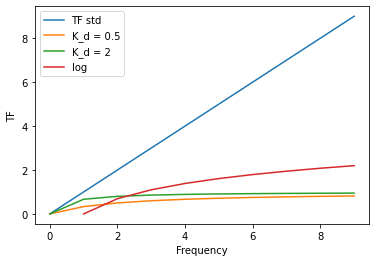

In [125]:
## Showing the effect of different 

print(type(example_tok))

plt.plot(x,x)
plt.plot(x,x/(x+2))
plt.plot(x,x/(x+0.5))
plt.plot(x, np.log(x))
plt.xlabel('Frequency')
plt.ylabel('TF')
plt.legend(['TF std','K_d = 0.5','K_d = 2','log'])

# Constructing TF matrices

In [181]:

# print(new_list)

tf_mat = np.zeros(shape = (N_d,N_t))
tf_mat = csr_matrix(tf_mat)
tf_idf = csr_matrix(tf_mat)
tf_sum = csr_matrix(tf_mat)
tf_frac = csr_matrix(tf_mat)
tf_log = csr_matrix(tf_mat)
tf_idf_bir = csr_matrix(tf_mat)

len_example = np.array(list(map(lambda b: len(b), example_tok)))
avg_len = np.mean(len_example)
K_d = len_example/avg_len

#term frequency and tfidf
for i in range(N_d):
    # i = 3
    tokens = example_tok[i]
    #print(tokens)

    words_count = len(example_tok[i])
    counter = Counter(example_tok[i])

    for token in new_list:
#         try:
        ind = new_list.index(token)

        tf = counter[token]/words_count
        tf2 = counter[token]

        tf_mat[i,ind] = tf2
        tf_sum[i,ind] = tf2/words_count
        tf_log[i,ind] = np.log(tf2 +1)
        tf_frac[i,ind] = tf2/(tf2 + K_d[i])

        tf_idf[i,ind] = tf_sum[i,ind]*idf[ind]
        tf_idf_bir[i,ind] = tf_sum[i,ind]*idf_bir[ind]
        #df1 = DF[token]
#         except:
#             print('blah')
#             pass

tf_mat = tf_mat.toarray()
tf_sum = tf_sum.toarray()
tf_log = tf_log.toarray()
tf_frac = tf_frac.toarray()
max_value = max(tf_mat[0])
min_value = min(tf_mat[0])


for row in tf_mat[1:]:   
    max_value = max(max_value, max(row))
    min_value = min(min_value, min(row))        
tf_max = tf_mat/max_value
tf_mat_df = pd.DataFrame(tf_mat,columns = new_list)
tf_idf_df = pd.DataFrame(tf_idf.toarray(),columns = new_list)
#print(tf_idf_df)

from scipy import stats
# print('standard')
# print_mat(tf_mat)
# print('sum')
# print_mat(tf_sum)
# print('log')
# print_mat(tf_log)

print_mat(tf_idf.toarray())


/Users/vm/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


    0     1    2     3     4     5     6     7     8    9     10    11
0  0.0  0.47  0.0  0.00  0.00  0.40  0.00  0.47  0.00  0.0  0.00  0.00
1  0.4  0.00  0.4  0.40  0.34  0.00  0.00  0.40  0.00  0.0  0.34  0.00
2  0.0  0.00  0.0  0.56  0.48  0.48  0.56  0.00  0.00  0.0  0.00  0.00
3  0.0  0.47  0.0  0.93  0.00  0.00  0.47  0.00  0.00  0.0  0.00  0.00
4  0.4  0.00  0.4  0.00  0.34  0.00  0.00  0.00  0.00  0.0  0.00  0.00
5  0.0  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.56  0.0  0.00  0.00
6  0.0  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.70  0.6  0.00  0.00
7  0.0  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.35  0.3  0.00  0.35
8  0.0  0.00  0.0  0.00  0.00  0.00  0.00  0.00  0.00  0.8  0.80  0.93


# Analysis standard

[0 0 0 0 0 0 0 0 1 1 1 1]
Examples from the paper, compare term from the same group and terms from different groups
human, computer
SpearmanrResult(correlation=0.8666666666666667, pvalue=0.0024953982859902053)
human, graph
SpearmanrResult(correlation=-0.7999999999999999, pvalue=0.00962792472537983)
Matrix of Spearman Correlations between terms for the Standard matrix


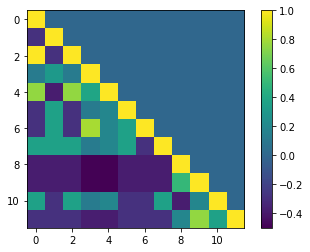

Matrix of Spearman Correlations for the Standard matrix with principal components


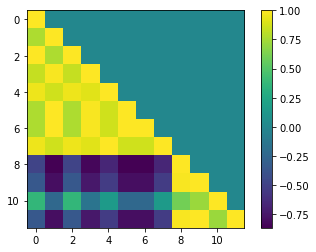

In [174]:
k =2
U,s,Vt = svds(tf_mat,k=k)
# print(np.transpose(Vt))
# print(U)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

kmeans = KMeans(n_clusters=k, random_state=0).fit(np.transpose(Vt))
print(kmeans.labels_)
# plt.scatter(U[:,0],U[:,4],U[:,5],c=kmeans.labels_.astype(float))

tf_hat = np.matmul(np.matmul(U,np.diag(s)),Vt)
# print(pd.DataFrame(tf_hat, columns = new_list))
y, rho =stats.spearmanr(tf_hat[:,2], tf_hat[:,4])
# print(y)
print('Examples from the paper, compare term from the same group and terms from different groups')
print(new_list[1] +', '+new_list[7])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,7]))
print(new_list[1] +', '+new_list[9])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,9]))
kmeans = KMeans(n_clusters=k, random_state=0).fit(U)


N_i = N_t
corr_raw = np.zeros([N_i,N_i])
corr = np.zeros([N_i,N_i])
for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_hat[:,i], tf_hat[:,j])
        corr[i][j] = t

for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_mat[:,i], tf_mat[:,j])
        corr_raw[i][j] = t
        

# N_i = N_d
# corr_raw = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_hat[i,:], tf_hat[j,:])
#         corr[i][j] = t
# corr = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_mat[i,:], tf_mat[j,:])
#         corr_raw[i][j] = t
        
        
print('Matrix of Spearman Correlations between terms for the Standard matrix')
plt.imshow(corr_raw,cmap='viridis')
plt.colorbar()
plt.show()
print('Matrix of Spearman Correlations for the Standard matrix with principal components')
plt.imshow(corr,cmap='viridis')
plt.colorbar()
plt.show()

# print_mat(corr_raw)


# Analysis TF_sum

Examples from the paper, compare term from the same group and terms from different groups
human, computer
SpearmanrResult(correlation=0.9, pvalue=0.0009430623223403293)
human, graph
SpearmanrResult(correlation=-0.8333333333333333, pvalue=0.005265691029161748)
Matrix of Spearman Correlations between terms for the TF_sum matrix


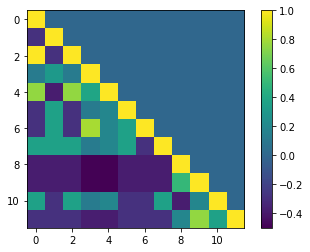

Matrix of Spearman Correlations for the TF_sum matrix with principal components


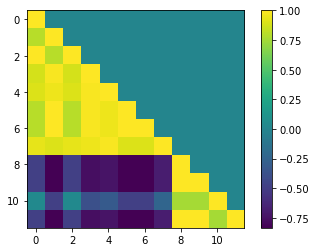

In [175]:
k =2
U,s,Vt = svds(tf_sum,k=k)
# print(np.transpose(Vt))
# print(U)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

kmeans = KMeans(n_clusters=k, random_state=0).fit(U)
# print(kmeans.labels_)
# plt.scatter(U[:,0],U[:,4],U[:,5],c=kmeans.labels_.astype(float))

tf_hat = np.matmul(np.matmul(U,np.diag(s)),Vt)
# print(pd.DataFrame(tf_hat, columns = new_list))
y, rho =stats.spearmanr(tf_hat[:,2], tf_hat[:,4])
# print(y)
print('Examples from the paper, compare term from the same group and terms from different groups')
print(new_list[1] +', '+new_list[7])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,7]))
print(new_list[1] +', '+new_list[9])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,9]))
kmeans = KMeans(n_clusters=k, random_state=0).fit(U)



N_i = N_t
corr_raw = np.zeros([N_i,N_i])
corr = np.zeros([N_i,N_i])
for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_hat[:,i], tf_hat[:,j])
        corr[i][j] = t

for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_mat[:,i], tf_mat[:,j])
        corr_raw[i][j] = t
        

# N_i = N_d
# corr_raw = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_hat[i,:], tf_hat[j,:])
#         corr[i][j] = t
# corr = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_mat[i,:], tf_mat[j,:])
#         corr_raw[i][j] = t
        
        
print('Matrix of Spearman Correlations between terms for the TF_sum matrix')
plt.imshow(corr_raw,cmap='viridis')
plt.colorbar()
plt.show()
print('Matrix of Spearman Correlations for the TF_sum matrix with principal components')
plt.imshow(corr,cmap='viridis')
plt.colorbar()
plt.show()

# Analysis TF_max

Examples from the paper, compare term from the same group and terms from different groups
human, computer
SpearmanrResult(correlation=0.8666666666666667, pvalue=0.0024953982859902053)
human, graph
SpearmanrResult(correlation=-0.7999999999999999, pvalue=0.00962792472537983)
Matrix of Spearman Correlations between terms for the TF_max matrix


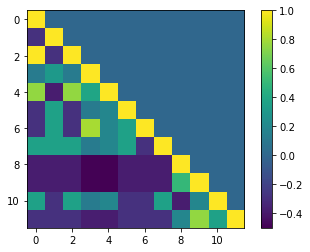

Matrix of Spearman Correlations for the TF_max matrix with principal components


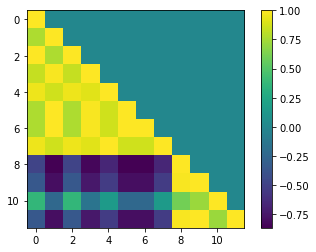

In [176]:
k =2
U,s,Vt = svds(tf_max,k=k)
# print(np.transpose(Vt))
# print(U)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

kmeans = KMeans(n_clusters=k, random_state=0).fit(U)
# print(kmeans.labels_)
# plt.scatter(U[:,0],U[:,4],U[:,5],c=kmeans.labels_.astype(float))

tf_hat = np.matmul(np.matmul(U,np.diag(s)),Vt)
# print(pd.DataFrame(tf_hat, columns = new_list))
y, rho =stats.spearmanr(tf_hat[:,2], tf_hat[:,4])
# print(y)
print('Examples from the paper, compare term from the same group and terms from different groups')
print(new_list[1] +', '+new_list[7])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,7]))
print(new_list[1] +', '+new_list[9])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,9]))
kmeans = KMeans(n_clusters=k, random_state=0).fit(U)

N_i = N_t
corr_raw = np.zeros([N_i,N_i])
corr = np.zeros([N_i,N_i])
for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_hat[:,i], tf_hat[:,j])
        corr[i][j] = t

for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_mat[:,i], tf_mat[:,j])
        corr_raw[i][j] = t
        

# N_i = N_d
# corr_raw = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_hat[i,:], tf_hat[j,:])
#         corr[i][j] = t
# corr = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_mat[i,:], tf_mat[j,:])
#         corr_raw[i][j] = t
        
        
print('Matrix of Spearman Correlations between terms for the TF_max matrix')
plt.imshow(corr_raw,cmap='viridis')
plt.colorbar()
plt.show()
print('Matrix of Spearman Correlations for the TF_max matrix with principal components')
plt.imshow(corr,cmap='viridis')
plt.colorbar()
plt.show()

# Analysis TF_log

Examples from the paper, compare term from the same group and terms from different groups
human, computer
SpearmanrResult(correlation=0.8833333333333333, pvalue=0.0015905004234978686)
human, graph
SpearmanrResult(correlation=-0.7833333333333333, pvalue=0.012519873019449882)
Matrix of Spearman Correlations between terms for the TF_lg matrix


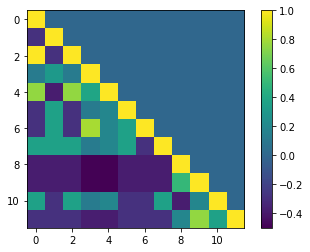

Matrix of Spearman Correlations for the TF_log matrix with principal components


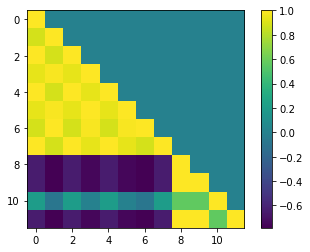

In [178]:
k =2
U,s,Vt = svds(tf_log,k=k)
# print(np.transpose(Vt))
# print(U)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

kmeans = KMeans(n_clusters=k, random_state=0).fit(U)
# print(kmeans.labels_)
# plt.scatter(U[:,0],U[:,4],U[:,5],c=kmeans.labels_.astype(float))

tf_hat = np.matmul(np.matmul(U,np.diag(s)),Vt)
# print(pd.DataFrame(tf_hat, columns = new_list))
y, rho =stats.spearmanr(tf_hat[:,2], tf_hat[:,4])
# print(y)
print('Examples from the paper, compare term from the same group and terms from different groups')
print(new_list[1] +', '+new_list[7])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,7]))
print(new_list[1] +', '+new_list[9])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,9]))
kmeans = KMeans(n_clusters=k, random_state=0).fit(U)

N_i = N_t
corr_raw = np.zeros([N_i,N_i])
corr = np.zeros([N_i,N_i])
for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_hat[:,i], tf_hat[:,j])
        corr[i][j] = t

for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_mat[:,i], tf_mat[:,j])
        corr_raw[i][j] = t
        

# N_i = N_d
# corr_raw = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_hat[i,:], tf_hat[j,:])
#         corr[i][j] = t
# corr = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_mat[i,:], tf_mat[j,:])
#         corr_raw[i][j] = t
        
        
print('Matrix of Spearman Correlations between terms for the TF_lg matrix')
plt.imshow(corr_raw,cmap='viridis')
plt.colorbar()
plt.show()
print('Matrix of Spearman Correlations for the TF_log matrix with principal components')
plt.imshow(corr,cmap='viridis')
plt.colorbar()
plt.show()

# TD-IDF

Examples from the paper, compare term from the same group and terms from different groups
human, computer
SpearmanrResult(correlation=0.8666666666666667, pvalue=0.0024953982859902053)
human, graph
SpearmanrResult(correlation=-0.8499999999999999, pvalue=0.0037047773275858133)
Matrix of Spearman Correlations between terms for the TF_IDF matrix


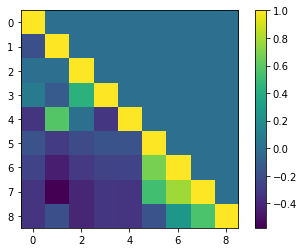

Matrix of Spearman Correlations for the TF_IDF matrix with principal components


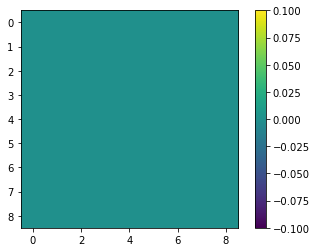

                                                   0
0    (0, 0)\t0.0\n  (0, 1)\t0.4652932448713425\n ...
1    (0, 0)\t0.3988227813182935\n  (0, 1)\t0.0\n ...
2    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...
3    (0, 0)\t0.0\n  (0, 1)\t0.4652932448713425\n ...
4    (0, 0)\t0.3988227813182935\n  (0, 1)\t0.0\n ...
5    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...
6    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...
7    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...
8    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...


In [179]:
k =2
U,s,Vt = svds(tf_idf,k=k)
# print(np.transpose(Vt))
# print(U)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

kmeans = KMeans(n_clusters=k, random_state=0).fit(U)
# print(kmeans.labels_)
# plt.scatter(U[:,0],U[:,4],U[:,5],c=kmeans.labels_.astype(float))

tf_hat = np.matmul(np.matmul(U,np.diag(s)),Vt)
# print(pd.DataFrame(tf_hat, columns = new_list))
y, rho =stats.spearmanr(tf_hat[:,2], tf_hat[:,4])
# print(y)
print('Examples from the paper, compare term from the same group and terms from different groups')
print(new_list[1] +', '+new_list[7])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,7]))
print(new_list[1] +', '+new_list[9])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,9]))
kmeans = KMeans(n_clusters=k, random_state=0).fit(U)

N_i = N_t
corr_raw = np.zeros([N_i,N_i])
corr = np.zeros([N_i,N_i])
for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_hat[:,i], tf_hat[:,j])
        corr[i][j] = t

for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_mat[:,i], tf_mat[:,j])
        corr_raw[i][j] = t
        

# N_i = N_d
# corr_raw = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_hat[i,:], tf_hat[j,:])
#         corr[i][j] = t
# corr = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_mat[i,:], tf_mat[j,:])
#         corr_raw[i][j] = t
        
        
print('Matrix of Spearman Correlations between terms for the TF_IDF matrix')
plt.imshow(corr_raw,cmap='viridis')
plt.colorbar()
plt.show()
print('Matrix of Spearman Correlations for the TF_IDF matrix with principal components')
plt.imshow(corr,cmap='viridis')
plt.colorbar()
plt.show()

print_mat(tf_idf)

# TFIDF BIR 

Examples from the paper, compare term from the same group and terms from different groups
human, computer
SpearmanrResult(correlation=0.9500000000000001, pvalue=8.762523965086177e-05)
human, graph
SpearmanrResult(correlation=-0.7666666666666667, pvalue=0.01594401657897401)
Matrix of Spearman Correlations between terms for the TF_IDF matrix


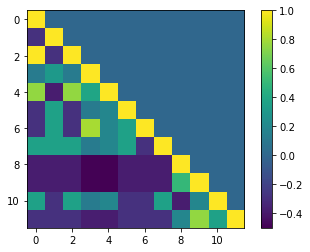

Matrix of Spearman Correlations for the TF_IDF matrix with principal components


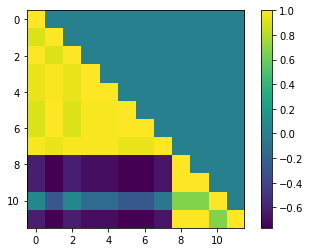

                                                   0
0    (0, 0)\t0.0\n  (0, 1)\t0.4652932448713425\n ...
1    (0, 0)\t0.3988227813182935\n  (0, 1)\t0.0\n ...
2    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...
3    (0, 0)\t0.0\n  (0, 1)\t0.4652932448713425\n ...
4    (0, 0)\t0.3988227813182935\n  (0, 1)\t0.0\n ...
5    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...
6    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...
7    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...
8    (0, 0)\t0.0\n  (0, 1)\t0.0\n  (0, 2)\t0.0\n ...


In [182]:
k =2
U,s,Vt = svds(tf_idf_bir,k=k)
# print(np.transpose(Vt))
# print(U)
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

kmeans = KMeans(n_clusters=k, random_state=0).fit(U)
# print(kmeans.labels_)
# plt.scatter(U[:,0],U[:,4],U[:,5],c=kmeans.labels_.astype(float))

tf_hat = np.matmul(np.matmul(U,np.diag(s)),Vt)
# print(pd.DataFrame(tf_hat, columns = new_list))
y, rho =stats.spearmanr(tf_hat[:,2], tf_hat[:,4])
# print(y)
print('Examples from the paper, compare term from the same group and terms from different groups')
print(new_list[1] +', '+new_list[7])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,7]))
print(new_list[1] +', '+new_list[9])
print(stats.spearmanr(tf_hat[:,1], tf_hat[:,9]))
kmeans = KMeans(n_clusters=k, random_state=0).fit(U)

N_i = N_t
corr_raw = np.zeros([N_i,N_i])
corr = np.zeros([N_i,N_i])
for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_hat[:,i], tf_hat[:,j])
        corr[i][j] = t

for i in range(N_i):
    for j in range(i+1):
        t,r = stats.spearmanr(tf_mat[:,i], tf_mat[:,j])
        corr_raw[i][j] = t
        

# N_i = N_d
# corr_raw = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_hat[i,:], tf_hat[j,:])
#         corr[i][j] = t
# corr = np.zeros([N_i,N_i])
# for i in range(N_i):
#     for j in range(i+1):
#         t,r = stats.spearmanr(tf_mat[i,:], tf_mat[j,:])
#         corr_raw[i][j] = t
        
        
print('Matrix of Spearman Correlations between terms for the TF_IDF matrix')
plt.imshow(corr_raw,cmap='viridis')
plt.colorbar()
plt.show()
print('Matrix of Spearman Correlations for the TF_IDF matrix with principal components')
plt.imshow(corr,cmap='viridis')
plt.colorbar()
plt.show()

print_mat(tf_idf)

# Other Notes

Burstiness - A term is said to be bursty if it is common in the documents it appears.

A good term is rare and occurs without burstiness (?) in the documents



In [ ]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_vector = tfidf_vectorizer.fit_transform(example)